# Set up

In [1]:
# Common imports
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# plot set up
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
# Suppress warnings related to deprecations
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Imbalanced Data

It is usually not guaranted the data we collected will always be balanced. We will look at what are the different ways we can utilize to deal with imblanced data.

The version of imbalanced-learn (0.9.1), and the version of scikit-learn is (1.1.1).

## Problem with metrics

0.9
0.9
0.9


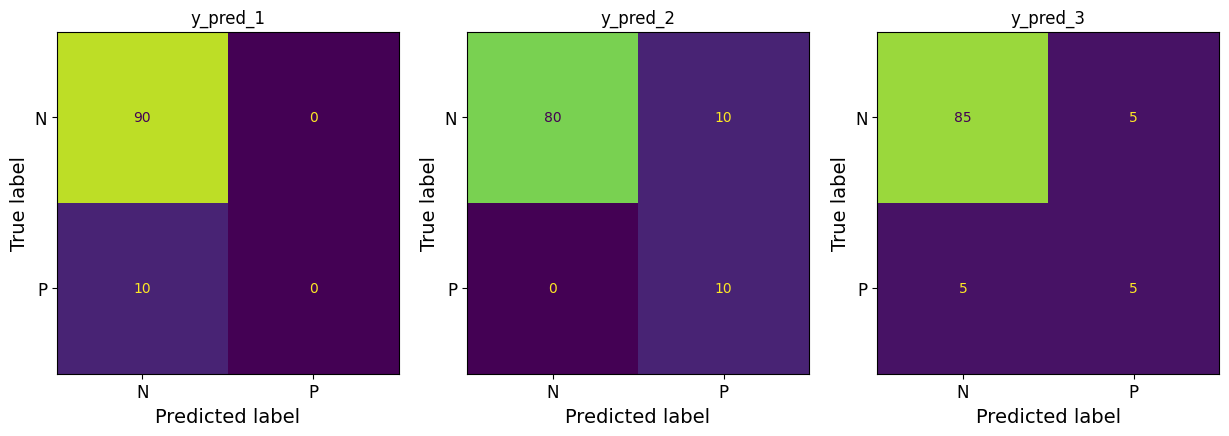

In [2]:
# Data with 10% positive
y_true = np.zeros(100, dtype=int)
y_true[:10] = 1
y_pred_1 = np.zeros(100, dtype=int)
y_pred_2 = y_true.copy()
y_pred_2[10:20] = 1
y_pred_3 = y_true.copy()
y_pred_3[5:15] = 1 - y_pred_3[5:15]

# all three predictors has accuracy of 0.9
for y_pred in [y_pred_1, y_pred_2, y_pred_3]:
    print(accuracy_score(y_true, y_pred))


# visualize confusion matrix for each
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import Normalize

fig, axes = plt.subplots(1, 3, figsize=(15,6))
for i, (ax, y_pred) in enumerate(zip(axes, [y_pred_1, y_pred_2, y_pred_3])):
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['N', 'P']).plot(ax=ax)
    ax.set_title("y_pred_{}".format(i + 1))
    ax.images[-1].colorbar.remove()
    ax.images[0].set_norm(Normalize(vmin=0, vmax=100))
plt.show()

In [3]:
rng = np.random.RandomState(0)

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

data = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, stratify=data.target, random_state=0)

lr = LogisticRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90        53
           1       0.93      0.96      0.95        90

    accuracy                           0.93       143
   macro avg       0.93      0.92      0.92       143
weighted avg       0.93      0.93      0.93       143



In [4]:
# how imbalanced the data is
np.bincount(y_train),np.bincount(y_test)

(array([159, 267]), array([53, 90]))

### Change threshold

We can set a different threshold at prediction, use `predict_prob` method, instead of the default one.

In [5]:
y_pred = lr.predict_proba(X_test)[:, 1]>0.85
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        53
           1       1.00      0.89      0.94        90

    accuracy                           0.93       143
   macro avg       0.92      0.94      0.93       143
weighted avg       0.94      0.93      0.93       143



### Change the model while training

The next thing we will look into is how to change the model directly.

First, we will use an extremely inbalanced data as the example

In [6]:
from sklearn.datasets import fetch_openml
data = fetch_openml('mammography')

In [7]:
X, y = data.data, data.target
y = (y.astype(int) + 1) // 2

# class distribution
np.bincount(y)

array([10923,   260])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [9]:
np.bincount(y_train), np.bincount(y_test)

(array([8192,  195]), array([2731,   65]))

Learn with two models: Logistic Regression and Random Forest

In [10]:
from sklearn.model_selection import cross_validate

scores = cross_validate(LogisticRegression(),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(np.float64(0.920142848522181), np.float64(0.635121042149257))

In [11]:
from sklearn.ensemble import RandomForestClassifier

scores = cross_validate(RandomForestClassifier(),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(np.float64(0.9481387137324235), np.float64(0.7396071603793475))

#### Downsampling
We will start with the simplest approach: downsampling. In `imbalanced-learn`, by default will provide a balanced dataset after sampling.

`RandomUnderSampling` in `imbalanced-learn` is downsampling the majority class, until the classes are balanced.

One advantage is downsampling could make the sample size much smaller and training process could be much faster.

In [12]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_resample(X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(8387, 6)
(390, 6)
[195 195]


In [13]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
# imblearn also has make_pipeline, to differentiate from the one in sklearn, import as a different name
undersample_pipe_lr = make_imb_pipeline(RandomUnderSampler(), LogisticRegression())
scores = cross_validate(undersample_pipe_lr,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))

print('Logistic Regression (Downsampling)')
print('AUC: %.2f, average precision: %.2f' % (scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()))

Logistic Regression (Downsampling)
AUC: 0.92, average precision: 0.53


#### Upsampling
We can see after downsampling, average precision goes down. However, by thowing away 95% of the training data, we still could get a reasonable prediction.

Also, it is important to look at different metrics: as we can get two different pictures by looking at *AUC* and *average precision* here.

Instead of downsampling, we can also do upsampling. In `RandomOverSampler`, we do sampling with replacement, which means we do random sampling in minority class, until it has the same number of instances as majority class. So the instances in minority class will appear multiple times.

In [14]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_resample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

(8387, 6)
(16384, 6)
[8192 8192]


In [15]:
oversample_pipe_lr = make_imb_pipeline(RandomOverSampler(), LogisticRegression())
scores = cross_validate(oversample_pipe_lr,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
print('Logistic Regression(Upsampling)')
print('AUC: %.2f, average precision: %.2f' % (scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()))

Logistic Regression(Upsampling)
AUC: 0.92, average precision: 0.58


With upsampling, the training time get much longer!

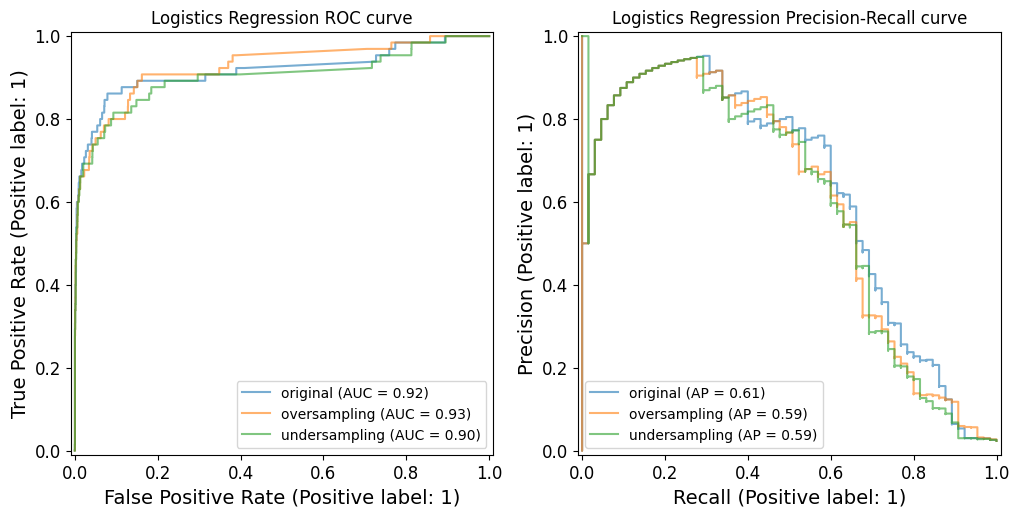

In [16]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
oversample_pipe_lr.fit(X_train, y_train)
undersample_pipe_lr.fit(X_train, y_train)
lr = LogisticRegression().fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
RocCurveDisplay.from_estimator(lr, X_test, y_test, name="original", ax=axes[0], alpha=0.6)
RocCurveDisplay.from_estimator(oversample_pipe_lr, X_test, y_test, name="oversampling", ax=axes[0], alpha=0.6)
RocCurveDisplay.from_estimator(undersample_pipe_lr, X_test, y_test, name="undersampling", ax=axes[0], alpha=0.6)
axes[0].set_title("Logistics Regression ROC curve")

PrecisionRecallDisplay.from_estimator(lr, X_test, y_test, name="original", ax=axes[1], alpha = 0.6)
PrecisionRecallDisplay.from_estimator(oversample_pipe_lr, X_test, y_test, name="oversampling", ax=axes[1], alpha = 0.6)
PrecisionRecallDisplay.from_estimator(undersample_pipe_lr, X_test, y_test, name="undersampling", ax=axes[1], alpha = 0.6)
axes[1].set_title("Logistics Regression Precision-Recall curve")
plt.show()

Random Forest (Downsampling)
AUC: 0.95, average precision: 0.58

Random Forest (Upsampling)
AUC: 0.93, average precision: 0.72



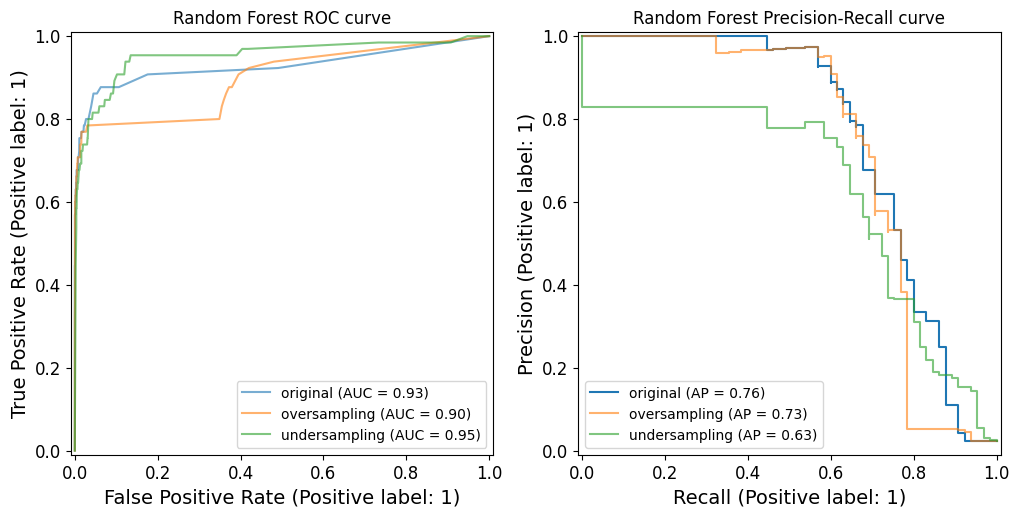

In [17]:
# do it again with random forest classifier
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier())
scores = cross_validate(undersample_pipe_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
print('Random Forest (Downsampling)')
print('AUC: %.2f, average precision: %.2f' % (scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()))

print()
oversample_pipe_rf = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier())
scores = cross_validate(oversample_pipe_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
print('Random Forest (Upsampling)')
print('AUC: %.2f, average precision: %.2f' % (scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()))

print ()

oversample_pipe_rf.fit(X_train, y_train)
undersample_pipe_rf.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=1).fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
RocCurveDisplay.from_estimator(rf, X_test, y_test, name="original", ax=axes[0], alpha = 0.6)
RocCurveDisplay.from_estimator(oversample_pipe_rf, X_test, y_test, name="oversampling", ax=axes[0], alpha = 0.6)
RocCurveDisplay.from_estimator(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[0], alpha = 0.6)
axes[0].set_title("Random Forest ROC curve")

PrecisionRecallDisplay.from_estimator(rf, X_test, y_test, name="original", ax=axes[1])
PrecisionRecallDisplay.from_estimator(oversample_pipe_rf, X_test, y_test, name="oversampling", ax=axes[1], alpha = 0.6)
PrecisionRecallDisplay.from_estimator(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[1], alpha = 0.6)
axes[1].set_title("Random Forest Precision-Recall curve")
plt.show()

#### class-weight hyperparameter in classifiers
Alternatively, we can use `class_weight` in `scikit-learn`. To re-weight loss function by the inverse by the frequnecy of each class.

For `class_weight`, if `None` by default, all classes are supposed to have weight 1.

The `balanced` mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

The `class_weight` has the same effect as upsampling, but not the same computation cost, since the dataset is not getting bigger.

In [18]:
scores = cross_validate(LogisticRegression(class_weight='balanced'),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
print('Logistic Regression(class weights)')
print('AUC: %.2f, average precision: %.2f' % (scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()))

print()
scores = cross_validate(RandomForestClassifier(class_weight='balanced'),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
print('Random Forest(class weights)')
print('AUC: %.2f, average precision: %.2f' % (scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()))

Logistic Regression(class weights)
AUC: 0.92, average precision: 0.58

Random Forest(class weights)
AUC: 0.92, average precision: 0.70


#### Ensemble resampling

Take Random Forest as an example: for each tree, we build a balanced sample, but it is different balancing for each tree. Each tree will be built as downsampling dataset, but they have different samples from the majority class.

In [19]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier


resampled_bagging = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(max_features='sqrt'),
                                         random_state=0, n_estimators=100)
scores = cross_validate(resampled_bagging,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
print('Balanced Bagging')
print('AUC: %.2f, average precision: %.2f' % (scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()))

print()

resampled_rf = BalancedRandomForestClassifier(random_state=0)
scores = cross_validate(resampled_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
print('Balanced Random Forest')
print('AUC: %.2f, average precision: %.2f' % (scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()))

Balanced Bagging
AUC: 0.95, average precision: 0.67

Balanced Random Forest
AUC: 0.95, average precision: 0.66


The result is slight worse than original data, but slightly better than downsampled data.

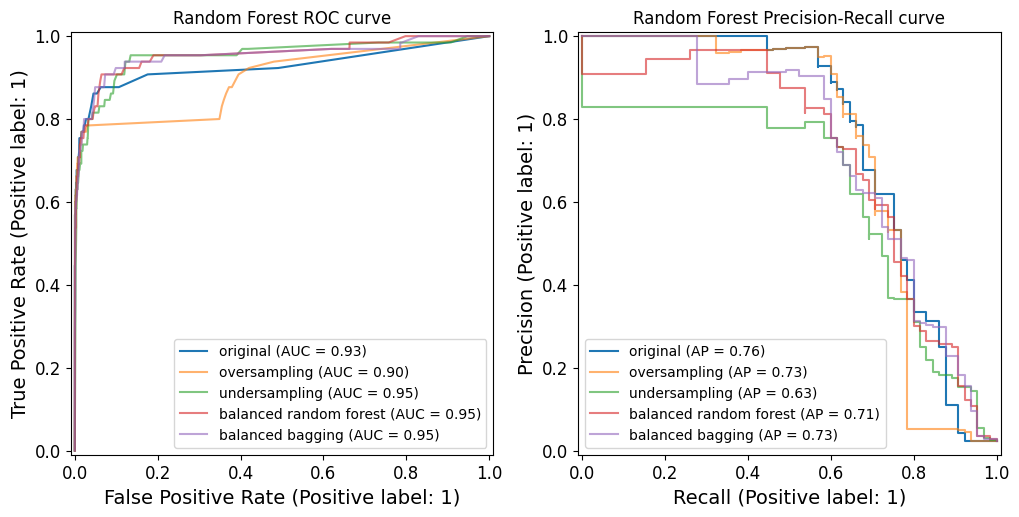

In [20]:
resampled_bagging.fit(X_train, y_train)
resampled_rf.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
RocCurveDisplay.from_estimator(rf, X_test, y_test, name="original", ax=axes[0])
RocCurveDisplay.from_estimator(oversample_pipe_rf, X_test, y_test, name="oversampling", ax=axes[0], alpha = 0.6)
RocCurveDisplay.from_estimator(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[0], alpha = 0.6)
RocCurveDisplay.from_estimator(resampled_rf, X_test, y_test, name="balanced random forest", ax=axes[0], alpha = 0.6)
RocCurveDisplay.from_estimator(resampled_bagging, X_test, y_test, name="balanced bagging", ax=axes[0], alpha = 0.6)
axes[0].set_title("Random Forest ROC curve")

PrecisionRecallDisplay.from_estimator(rf, X_test, y_test, name="original", ax=axes[1])
PrecisionRecallDisplay.from_estimator(oversample_pipe_rf, X_test, y_test, name="oversampling", ax=axes[1], alpha = 0.6)
PrecisionRecallDisplay.from_estimator(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[1], alpha = 0.6)
PrecisionRecallDisplay.from_estimator(resampled_rf, X_test, y_test, name="balanced random forest", ax=axes[1], alpha = 0.6)
PrecisionRecallDisplay.from_estimator(resampled_bagging, X_test, y_test, name="balanced bagging", ax=axes[1], alpha = 0.6)
axes[1].set_title("Random Forest Precision-Recall curve")

plt.show()

#### Synthetic Minority Oversampling Technique (SMOTE)

SMOTE is trying to add new instances that look like the original training set.

- add synthetic interpolated data to smaller class
- for each instance in minority class:
    * pick a random neighbor from k neighbors
    * pick point on line connecting the two uniformly (or with rectangle)
    * repeat the precess

In [21]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(np.bincount(y_train_smote))

[8192 8192]


In [22]:
X_train

,attr1,attr2,attr3,attr4,attr5,attr6
7643,-0.784415,-0.470195,-0.591631,-0.859553,-0.377866,-0.945723
5800,1.169248,2.732493,0.039510,2.778451,-0.377866,1.053178
5552,-0.784415,-0.470195,-0.591631,-0.859553,-0.377866,-0.945723
4988,-0.112811,-0.372876,-0.230979,0.888141,-0.377866,1.111073
1258,-0.784415,-0.470195,-0.591631,-0.859553,-0.377866,-0.945723
...,...,...,...,...,...,...
10261,-0.119926,-0.244592,1.166549,0.066615,-0.377866,0.903870
3817,-0.784415,-0.470195,-0.591631,-0.859553,-0.377866,-0.945723
8736,-0.784415,-0.470195,-0.591631,-0.859553,-0.377866,-0.945723
10974,-0.054713,-0.452501,-0.230979,-0.859553,-0.377866,-0.945723


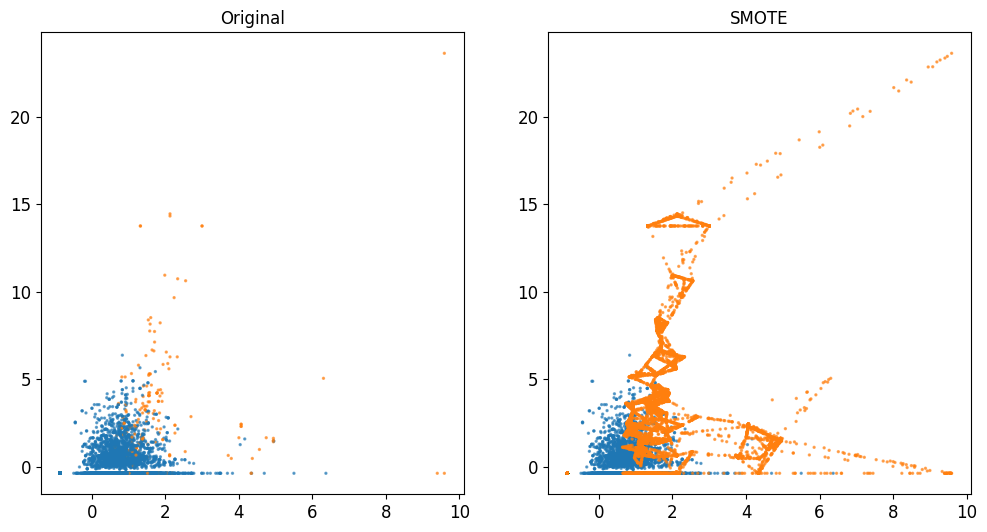

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sorting = np.argsort(y_train)
axes[0].scatter(X_train['attr4'], X_train['attr5'], c=plt.cm.tab10(y_train), alpha=.6, s=2)
axes[1].scatter(X_train_smote['attr4'], X_train_smote['attr5'], c=plt.cm.tab10(y_train_smote), alpha=.6, s=2)
axes[0].set_title("Original")
axes[1].set_title("SMOTE")
plt.show()

In [24]:
smote_pipe_lr = make_imb_pipeline(SMOTE(), LogisticRegression())
scores = cross_validate(smote_pipe_lr, X_train, y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
print('Logistic Regression(SMOTE)')
print('AUC: %.2f, average precision: %.2f' % (scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()))

print()

smote_pipe_rf = make_imb_pipeline(SMOTE(), RandomForestClassifier())
scores = cross_validate(smote_pipe_rf, X_train, y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
print('Random Forest(SMOTE)')
print('AUC: %.2f, average precision: %.2f' % (scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()))

Logistic Regression(SMOTE)
AUC: 0.92, average precision: 0.58

Random Forest(SMOTE)
AUC: 0.95, average precision: 0.68


In [25]:
smote_pipe_rf

Pipeline(steps=[('smote', SMOTE()),
                ('randomforestclassifier', RandomForestClassifier())])

In [26]:
from sklearn.model_selection import GridSearchCV
param_grid = {'smote__k_neighbors': [3, 5, 7, 9, 11, 15, 31]}
search = GridSearchCV(smote_pipe_rf, param_grid, cv=10, return_train_score=True, scoring="average_precision")
search.fit(X_train, y_train)
search.best_estimator_

Pipeline(steps=[('smote', SMOTE(k_neighbors=11)),
                ('randomforestclassifier', RandomForestClassifier())])

In [27]:
search.best_score_, search.best_params_

(np.float64(0.7001727022530035), {'smote__k_neighbors': 11})

<Figure size 600x600 with 0 Axes>

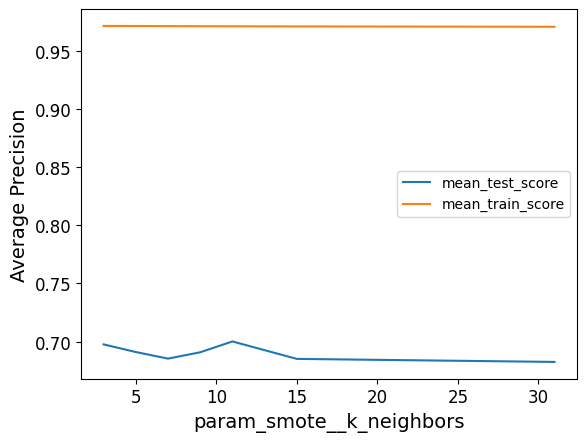

In [28]:
import pandas as pd

plt.figure(figsize=(6,6))
results = pd.DataFrame(search.cv_results_)
results.plot("param_smote__k_neighbors", ["mean_test_score", "mean_train_score"])
plt.ylabel("Average Precision", fontsize = 14)
plt.show()

In [29]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_smote__k_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,2.709799,0.497065,0.020029,0.002817,3,{'smote__k_neighbors': 3},0.767920,0.695301,0.642101,0.708012,...,0.967997,0.968028,0.973327,0.967989,0.978651,0.968206,0.973478,0.968187,0.971283,0.003525
1,2.627228,0.227431,0.021153,0.003310,5,{'smote__k_neighbors': 5},0.744876,0.656797,0.650920,0.692987,...,0.967952,0.967976,0.973226,0.967946,0.978514,0.968174,0.973438,0.968172,0.971222,0.003496
2,2.642197,0.271505,0.022356,0.005539,7,{'smote__k_neighbors': 7},0.710237,0.609408,0.704184,0.722560,...,0.967897,0.967896,0.973091,0.967869,0.978435,0.968067,0.973320,0.968005,0.971117,0.003494
3,2.739757,0.247828,0.021068,0.004693,9,{'smote__k_neighbors': 9},0.747313,0.678943,0.690775,0.729567,...,0.967738,0.967817,0.972967,0.967815,0.978363,0.967950,0.973149,0.967978,0.971018,0.003489
4,2.737965,0.244804,0.021982,0.004781,11,{'smote__k_neighbors': 11},0.796686,0.666385,0.701887,0.708588,...,0.967734,0.967739,0.972957,0.967666,0.978354,0.967920,0.973058,0.967899,0.970956,0.003501


In [30]:
scores = cross_validate(search.best_estimator_, X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
print('Random Forest(SMOTE: 3 neighbors)')
print('AUC: %.2f, average precision: %.2f' % (scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

Random Forest(SMOTE: 3 neighbors)
AUC: 0.95, average precision: 0.70


(np.float64(0.9544720462820591), np.float64(0.70232680792287))

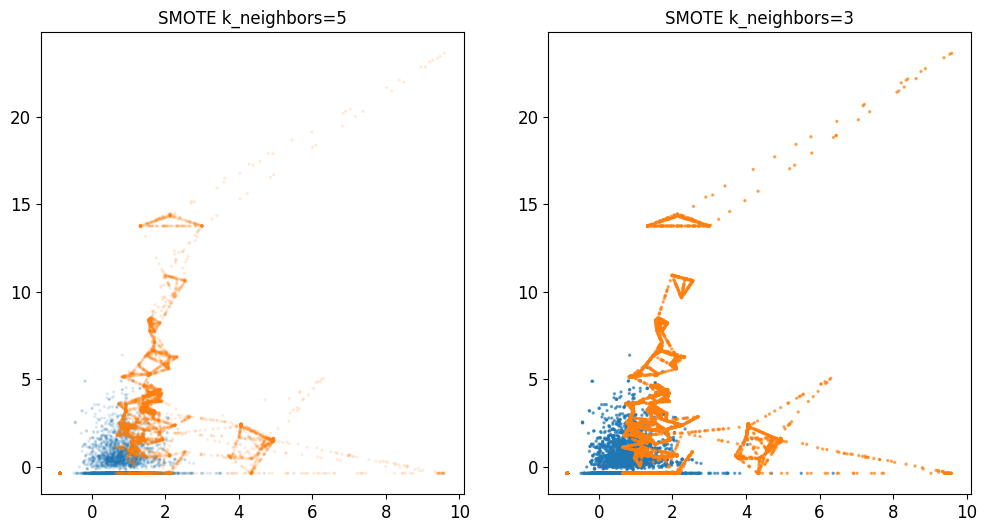

In [31]:
X_train_smote_best, y_train_smote_best = SMOTE(k_neighbors=3).fit_resample(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(X_train_smote['attr4'], X_train_smote['attr5'], c=plt.cm.tab10(y_train_smote), alpha=.1, s=2)
axes[1].scatter(X_train_smote_best['attr4'], X_train_smote_best['attr5'], c=plt.cm.tab10(y_train_smote_best), alpha=.6, s=2)
axes[0].set_title("SMOTE k_neighbors=5")
axes[1].set_title("SMOTE k_neighbors=3")
plt.show()

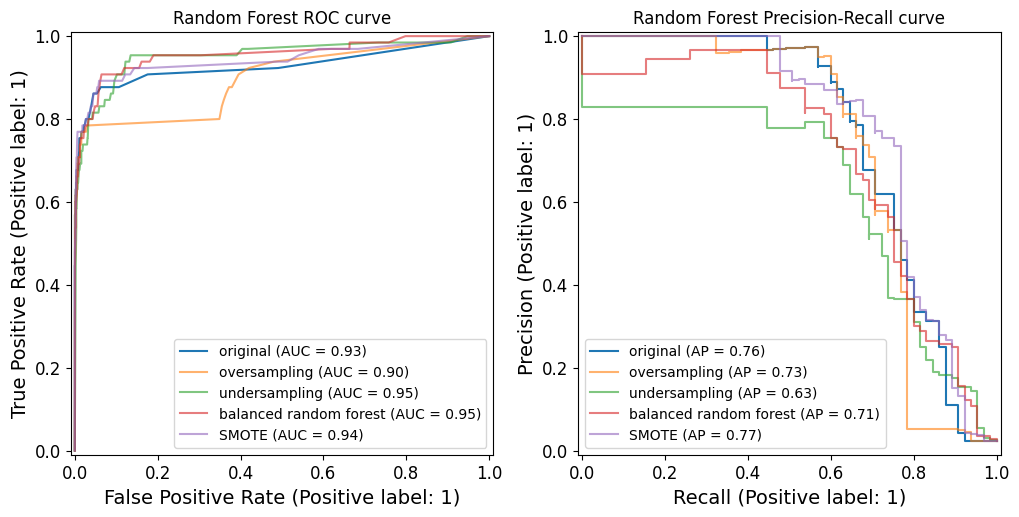

In [32]:
search.best_estimator_.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
RocCurveDisplay.from_estimator(rf, X_test, y_test, name="original", ax=axes[0])
RocCurveDisplay.from_estimator(oversample_pipe_rf, X_test, y_test, name="oversampling", ax=axes[0], alpha = 0.6)
RocCurveDisplay.from_estimator(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[0], alpha = 0.6)
RocCurveDisplay.from_estimator(resampled_rf, X_test, y_test, name="balanced random forest", ax=axes[0], alpha = 0.6)
RocCurveDisplay.from_estimator(search.best_estimator_, X_test, y_test, name="SMOTE", ax=axes[0], alpha = 0.6)
axes[0].set_title("Random Forest ROC curve")

PrecisionRecallDisplay.from_estimator(rf, X_test, y_test, name="original", ax=axes[1])
PrecisionRecallDisplay.from_estimator(oversample_pipe_rf, X_test, y_test, name="oversampling", ax=axes[1], alpha = 0.6)
PrecisionRecallDisplay.from_estimator(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[1], alpha = 0.6)
PrecisionRecallDisplay.from_estimator(resampled_rf, X_test, y_test, name="balanced random forest", ax=axes[1], alpha = 0.6)
PrecisionRecallDisplay.from_estimator(search.best_estimator_, X_test, y_test, name="SMOTE", ax=axes[1], alpha = 0.6)
axes[1].set_title("Random Forest Precision-Recall curve")

plt.show()

Balanced bagging is as fast as the downsampling, these two are way faster than the rest approaches.